We will follow the structure:
[Data Input/Stream]
       ↓
[Out-of-Distribution Detection]
       ↓
[Task Boundary Detector/Scheduler] → [Replay Buffer]
       ↓                                 ↑↓
[Neural Network Model] ←──────────────────┘
       ↓
[Regularization Mechanism]
       ↓
[Loss Function]
       ↓
[Training Loop/Optimizer]
       ↓
[Evaluation Module]

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms as transforms
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import copy
import os
from typing import Dict, List, Optional, Union, Any
import logging
import json
import os
from datetime import datetime
import pandas as pd


# DataLoader

In [2]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import random
from collections import defaultdict

class ImprovedTaskSplitter:
    """
    Improved task splitting strategies for Online Continual Learning
    that considers feature similarity and task difficulty balance.
    """
    
    def __init__(self, strategy='adaptive_clustering', random_seed=42):
        """
        Args:
            strategy: 'adaptive_clustering', 'similarity_based', 'balanced_difficulty', 'random'
        """
        self.strategy = strategy
        self.random_seed = random_seed
        np.random.seed(random_seed)
        random.seed(random_seed)
    
    def extract_class_features(self, base_dataset, model, device, batch_size=128):
        """
        Extract representative features for each class using a pretrained model
        or initial model state. This helps create semantically meaningful task splits.
        """
        model.eval()
        
        # Get labels
        if hasattr(base_dataset, 'targets'):
            labels = base_dataset.targets
        elif hasattr(base_dataset, 'labels'):
            labels = base_dataset.labels
        else:
            labels = [base_dataset[i][1] for i in range(len(base_dataset))]
        
        classes = sorted(set(labels))
        class_features = {}
        
        # Group samples by class
        class_to_indices = defaultdict(list)
        for idx, label in enumerate(labels):
            class_to_indices[label].append(idx)
        
        with torch.no_grad():
            for cls in classes:
                indices = class_to_indices[cls][:min(100, len(class_to_indices[cls]))]  # Sample max 100 per class
                
                features_list = []
                for i in range(0, len(indices), batch_size):
                    batch_indices = indices[i:i+batch_size]
                    batch_data = torch.stack([base_dataset[idx][0] for idx in batch_indices])
                    batch_data = batch_data.to(device)
                    
                    _, features = model(batch_data)  # Assuming model returns (logits, features)
                    features_list.append(features.cpu())
                
                all_features = torch.cat(features_list, dim=0)
                class_features[cls] = all_features.mean(dim=0).numpy()  # Average feature per class
        
        return class_features
    
    def adaptive_clustering_split(self, classes, class_features, n_tasks):
        """
        Use clustering on class features to group similar classes together,
        then split clusters across tasks to maximize inter-task diversity.
        """
        if len(classes) < n_tasks:
            raise ValueError(f"Number of classes ({len(classes)}) must be >= n_tasks ({n_tasks})")
        
        # Extract feature matrix
        feature_matrix = np.array([class_features[cls] for cls in classes])
        
        # Cluster classes into more clusters than tasks
        n_clusters = min(n_tasks * 2, len(classes))
        kmeans = KMeans(n_clusters=n_clusters, random_state=self.random_seed)
        cluster_labels = kmeans.fit_predict(feature_matrix)
        
        # Group classes by cluster
        clusters = defaultdict(list)
        for cls, cluster_id in zip(classes, cluster_labels):
            clusters[cluster_id].append(cls)
        
        # Distribute clusters across tasks to balance difficulty and diversity
        task_assignments = [[] for _ in range(n_tasks)]
        cluster_ids = list(clusters.keys())
        
        # Sort clusters by size (larger clusters first)
        cluster_ids.sort(key=lambda x: len(clusters[x]), reverse=True)
        
        # Assign clusters to tasks in round-robin fashion
        for i, cluster_id in enumerate(cluster_ids):
            task_id = i % n_tasks
            task_assignments[task_id].extend(clusters[cluster_id])
        
        return task_assignments
    
    def similarity_based_split(self, classes, class_features, n_tasks):
        """
        Split classes based on feature similarity to minimize within-task similarity
        and maximize between-task diversity.
        """
        feature_matrix = np.array([class_features[cls] for cls in classes])
        similarity_matrix = cosine_similarity(feature_matrix)
        
        task_assignments = [[] for _ in range(n_tasks)]
        remaining_classes = set(classes)
        
        for task_id in range(n_tasks):
            if not remaining_classes:
                break
                
            if task_id == 0:
                # Start with a random class for first task
                selected = random.choice(list(remaining_classes))
                task_assignments[task_id].append(selected)
                remaining_classes.remove(selected)
            
            # For each task, select classes that are diverse from already assigned classes
            target_size = len(classes) // n_tasks + (1 if task_id < len(classes) % n_tasks else 0)
            
            while len(task_assignments[task_id]) < target_size and remaining_classes:
                # Find class with minimum similarity to current task classes
                best_class = None
                min_max_similarity = float('inf')
                
                for candidate in remaining_classes:
                    candidate_idx = classes.index(candidate)
                    max_similarity = 0
                    
                    for assigned_class in task_assignments[task_id]:
                        assigned_idx = classes.index(assigned_class)
                        similarity = similarity_matrix[candidate_idx][assigned_idx]
                        max_similarity = max(max_similarity, similarity)
                    
                    if max_similarity < min_max_similarity:
                        min_max_similarity = max_similarity
                        best_class = candidate
                
                if best_class:
                    task_assignments[task_id].append(best_class)
                    remaining_classes.remove(best_class)
        
        # Assign any remaining classes
        for i, remaining_class in enumerate(remaining_classes):
            task_assignments[i % n_tasks].append(remaining_class)
            
        return task_assignments
    
    def balanced_difficulty_split(self, base_dataset, classes, n_tasks):
        """
        Split classes to balance task difficulty based on class frequency
        and intra-class variance.
        """
        # Get labels
        if hasattr(base_dataset, 'targets'):
            labels = base_dataset.targets
        elif hasattr(base_dataset, 'labels'):
            labels = base_dataset.labels
        else:
            labels = [base_dataset[i][1] for i in range(len(base_dataset))]
        
        # Calculate class statistics
        class_stats = {}
        for cls in classes:
            class_indices = [i for i, label in enumerate(labels) if label == cls]
            class_stats[cls] = {
                'count': len(class_indices),
                'difficulty': 1.0 / len(class_indices)  # Inverse frequency as difficulty proxy
            }
        
        # Sort classes by difficulty
        sorted_classes = sorted(classes, key=lambda x: class_stats[x]['difficulty'], reverse=True)
        
        # Distribute classes to balance total difficulty per task
        task_assignments = [[] for _ in range(n_tasks)]
        task_difficulties = [0.0 for _ in range(n_tasks)]
        
        for cls in sorted_classes:
            # Assign to task with minimum current difficulty
            min_task = min(range(n_tasks), key=lambda x: task_difficulties[x])
            task_assignments[min_task].append(cls)
            task_difficulties[min_task] += class_stats[cls]['difficulty']
        
        return task_assignments
    
    def create_task_loaders(self, base_dataset, n_tasks, batch_size=64, 
                           model=None, device=None, shuffle_tasks=True):
        """
        Create improved task loaders using the specified splitting strategy.
        """
        # Get labels and classes
        if hasattr(base_dataset, 'targets'):
            labels = base_dataset.targets
        elif hasattr(base_dataset, 'labels'):
            labels = base_dataset.labels
        else:
            labels = [base_dataset[i][1] for i in range(len(base_dataset))]
        
        classes = sorted(set(labels))
        num_classes = len(classes)
        
        if n_tasks > num_classes:
            raise ValueError(f"n_tasks ({n_tasks}) > number of classes ({num_classes})")
        
        # Apply splitting strategy
        if self.strategy == 'adaptive_clustering' and model is not None:
            class_features = self.extract_class_features(base_dataset, model, device)
            task_class_assignments = self.adaptive_clustering_split(classes, class_features, n_tasks)
        elif self.strategy == 'similarity_based' and model is not None:
            class_features = self.extract_class_features(base_dataset, model, device)
            task_class_assignments = self.similarity_based_split(classes, class_features, n_tasks)
        elif self.strategy == 'balanced_difficulty':
            task_class_assignments = self.balanced_difficulty_split(base_dataset, classes, n_tasks)
        else:  # fallback to random
            if shuffle_tasks:
                random.shuffle(classes)
            classes_per_task = num_classes // n_tasks
            remainder = num_classes % n_tasks
            task_class_assignments = []
            idx = 0
            for t in range(n_tasks):
                count = classes_per_task + (1 if t < remainder else 0)
                task_class_assignments.append(classes[idx:idx + count])
                idx += count
        
        # Create class to indices mapping
        class_to_indices = {cls: [] for cls in classes}
        for idx, label in enumerate(labels):
            class_to_indices[label].append(idx)
        
        # Create task splits
        task_splits = []
        for task_classes in task_class_assignments:
            indices = []
            for cls in task_classes:
                indices.extend(class_to_indices[cls])
            if shuffle_tasks:
                random.shuffle(indices)
            task_splits.append(indices)
        
        # Custom Dataset class
        class TaskDataset(Dataset):
            def __init__(self, base_dataset, indices):
                self.base_dataset = base_dataset
                self.indices = indices
            
            def __len__(self):
                return len(self.indices)
            
            def __getitem__(self, idx):
                return self.base_dataset[self.indices[idx]]
        
        # Create loader functions
        def train_loader_fn(task_id):
            dataset = TaskDataset(base_dataset, task_splits[task_id])
            return DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        def test_loader_fn(task_id):
            dataset = TaskDataset(base_dataset, task_splits[task_id])
            return DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        return train_loader_fn, test_loader_fn, task_class_assignments

In [3]:
from torch.utils.data import DataLoader, Dataset

class OnlineStreamDataset(Dataset):
    """
    Wraps a dataset to simulate an online data stream for continual learning.
    Each task is a slice of the dataset.
    """
    def __init__(self, base_dataset, task_indices):
        """
        Args:
            base_dataset: The full dataset (e.g., torchvision.datasets.CIFAR10).
            task_indices: List of indices for the current task's data.
        """
        self.base_dataset = base_dataset
        self.task_indices = task_indices

    def __len__(self):
        return len(self.task_indices)

    def __getitem__(self, idx):
        real_idx = self.task_indices[idx]
        return self.base_dataset[real_idx]

def create_online_stream_loaders(base_dataset, n_tasks, batch_size=32, shuffle=True):
    """
    Splits the dataset into n_tasks and returns train and test loader functions.
    """
    total_len = len(base_dataset)
    indices = torch.randperm(total_len).tolist()
    task_splits = [indices[i::n_tasks] for i in range(n_tasks)]

    def train_loader_fn(task_id):
        dataset = OnlineStreamDataset(base_dataset, task_splits[task_id])
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    def test_loader_fn(task_id):
        dataset = OnlineStreamDataset(base_dataset, task_splits[task_id])
        return DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return train_loader_fn, test_loader_fn

In [4]:
from torch.utils.data import DataLoader, Dataset

class OnlineStreamDataset(Dataset):
    """
    Wraps a dataset to simulate an online data stream for continual learning.
    Each task is a slice of the dataset.
    """
    def __init__(self, base_dataset, task_indices):
        """
        Args:
            base_dataset: The full dataset (e.g., torchvision.datasets.CIFAR10).
            task_indices: List of indices for the current task's data.
        """
        self.base_dataset = base_dataset
        self.task_indices = task_indices

    def __len__(self):
        return len(self.task_indices)

    def __getitem__(self, idx):
        real_idx = self.task_indices[idx]
        return self.base_dataset[real_idx]

def create_online_stream_loaders(base_dataset, n_tasks, batch_size=32, shuffle=True):
    """
    Splits the dataset into n_tasks and returns train and test loader functions.
    """
    total_len = len(base_dataset)
    indices = torch.randperm(total_len).tolist()
    task_splits = [indices[i::n_tasks] for i in range(n_tasks)]

    def train_loader_fn(task_id):
        dataset = OnlineStreamDataset(base_dataset, task_splits[task_id])
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    def test_loader_fn(task_id):
        dataset = OnlineStreamDataset(base_dataset, task_splits[task_id])
        return DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return train_loader_fn, test_loader_fn

In [5]:
from torch.utils.data import DataLoader, Dataset

def create_offline_task_loaders(train_dataset, test_dataset, n_tasks=5, batch_size=64, shuffle=True):
    """
    Splits the datasets into n_tasks for offline continual learning.
    Returns two functions: train_loader_fn(task_id), test_loader_fn(task_id).
    """
    train_len = len(train_dataset)
    test_len = len(test_dataset)
    
    train_indices = torch.randperm(train_len).tolist()
    test_indices = torch.randperm(test_len).tolist()
    
    train_task_splits = [train_indices[i::n_tasks] for i in range(n_tasks)]
    test_task_splits = [test_indices[i::n_tasks] for i in range(n_tasks)]

    class TaskDataset(Dataset):
        def __init__(self, base_dataset, indices):
            self.base_dataset = base_dataset
            self.indices = indices
        def __len__(self):
            return len(self.indices)
        def __getitem__(self, idx):
            return self.base_dataset[self.indices[idx]]

    def train_loader_fn(task_id):
        dataset = TaskDataset(train_dataset, train_task_splits[task_id])
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    def test_loader_fn(task_id):
        dataset = TaskDataset(test_dataset, test_task_splits[task_id])
        return DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return train_loader_fn, test_loader_fn

# Out of Distribution Detection
For OOD task, we will consider 3 different approaches:
- First, we will use Energy Based OOD Model (Deep Learning Approach)
- Second, we will use Mahalanobis Distance OOD
- Finally, we will use confidence based approach: Softmax-Based OOD
## Energy Based OOD Detection
Write a lot of function and calculation here
The formular is E_c = - logsumexp(f_c(x)) to calculate energy

In [6]:
import torch

class EnergyDetector:
    def __init__(self):
        self.tau = None

    def fit(self, model, buffer, device, reg_cov=1e-5):
        # No parameters to fit for energy-based detector, as it relies directly on the model's logits.
        # This method is included for structural compatibility with MahalanobisDetector.
        pass

    def score(self, model, x, device):
        model.eval()
        with torch.no_grad():
            logits, _ = model(x) # Model returns (logits, features)
        # Compute energy score: -logsumexp(logits, dim=1)
        energies = -torch.logsumexp(logits, dim=1)
        return energies

    def detect(self, model, x, device):
        return self.score(model, x, device) > self.tau

    def set_threshold(self, model, buffer, device, false_positive_rate=0.2):
        X_id, _ = buffer.get_all_data()
        if X_id is None:
            return
        e_id = []
        for i in range(0, len(X_id), 256):
            batch = X_id[i:i+256].to(device).float()
            e_id.append(self.score(model, batch, device))
        e_id = torch.cat(e_id)
        self.tau = torch.quantile(e_id, 1 - false_positive_rate).item()

## Mahalanobis Detector

In [7]:
class MahalanobisDetector:
    def __init__(self):
        self.class_means = {}
        self.precision = None
        self.tau = None

    def fit(self, model, buffer, device, reg_cov=1e-5):
        model.eval()
        X, Y = buffer.get_all_data()
        if X is None:
            return
        X, Y = X.to(device), Y.to(device)
        feats = []
        with torch.no_grad():
            for i in range(0, len(X), 256):
                batch = X[i:i+256].float()
                f, _ = model(batch) # Model returns (logits, features)
                feats.append(f)
        feats = torch.cat(feats, dim=0)
        for c in torch.unique(Y):
            self.class_means[int(c.item())] = feats[Y==c].mean(dim=0)
        centered = feats - torch.stack([self.class_means[int(y.item())] for y in Y])
        cov = (centered.t() @ centered) / (len(Y)-1)
        cov += reg_cov * torch.eye(cov.size(0)).to(device)
        self.precision = torch.inverse(cov)

    def score(self, model, x, device):
        model.eval()
        with torch.no_grad():
            _, f = model(x) # Model returns (logits, features)
        dists = []
        for mu in self.class_means.values():
            diff = f - mu.unsqueeze(0)
            dists.append(torch.sum(diff @ self.precision * diff, dim=1))
        dists = torch.stack(dists, dim=1)
        # print(f"dists={dists}")
        return dists.min(dim=1)[0]

    def detect(self, model, x, device):
        return self.score(model, x, device) > self.tau

    def set_threshold(self, model, buffer, device, false_positive_rate=0.2):
        X_id, _ = buffer.get_all_data()
        if X_id is None:
            return
        d_id = []
        for i in range(0, len(X_id), 256):
            d_id.append(self.score(model, X_id[i:i+256].to(device), device))
        d_id = torch.cat(d_id)
        self.tau = torch.quantile(d_id, 1 - false_positive_rate).item()

## Softmax Based OOD Detector

In [8]:
import torch
import torch.nn.functional as F

class SoftmaxDetector:
    def __init__(self):
        self.tau = None

    def fit(self, model, buffer, device, reg_cov=1e-5):
        # No parameters to fit for softmax-based detector, as it relies directly on the model's logits.
        # This method is included for structural compatibility with other detectors.
        pass

    def score(self, model, x, device):
        model.eval()
        with torch.no_grad():
            logits, _ = model(x) # Model returns (logits, features)
        probs = F.softmax(logits, dim=1)
        max_probs = probs.max(dim=1)[0]
        # Score is -max_prob: lower (more negative) for ID (high confidence), higher (less negative) for OOD (low confidence)
        return -max_probs

    def detect(self, model, x, device):
        return self.score(model, x, device) > self.tau

    def set_threshold(self, model, buffer, device, false_positive_rate=0.2):
        X_id, _ = buffer.get_all_data()
        if X_id is None:
            return
        s_id = []
        for i in range(0, len(X_id), 256):
            batch = X_id[i:i+256].to(device).float()
            s_id.append(self.score(model, batch, device))
        s_id = torch.cat(s_id)
        self.tau = torch.quantile(s_id, 1 - false_positive_rate).item()

# Task Boundary Detector
For this one, we may disable in Offline CL
## Loss Based (Online-LoRA)

In [9]:
import torch
import torch.nn as nn
import numpy as np
from collections import deque

class LossBasedTaskBoundaryDetector:
    """A module for detecting task boundaries in online CL using loss-based signals."""
    
    def __init__(self, model, loss_fn=nn.CrossEntropyLoss(), window_size=100, 
                 threshold_factor=2.0, buffer_size=1000):
        """
        Initialize the task boundary detector.
        
        Args:
            model: PyTorch model (nn.Module) to monitor for loss changes.
            loss_fn: Loss function (default: CrossEntropyLoss).
            window_size: Number of samples for sliding window loss averaging.
            threshold_factor: Multiplier for dynamic threshold (mean + factor * std).
            buffer_size: Maximum size of replay buffer for storing past task samples.
        """
        self.model = model
        self.loss_fn = loss_fn
        self.window_size = window_size
        self.threshold_factor = threshold_factor
        self.buffer_size = buffer_size
        
        # Track losses in a sliding window
        self.loss_window = deque(maxlen=window_size)
        self.replay_buffer = deque(maxlen=buffer_size)
        self.task_id = 0  # Current task ID
        self.mean_loss = 0.0
        self.std_loss = 1.0  # Avoid division by zero
        
    def update_loss(self, inputs, targets):
        """
        Compute and store loss for a batch of data.
        
        Args:
            inputs: Input tensor (batch).
            targets: Target tensor (batch).
        
        Returns:
            float: Current batch loss.
        """
        self.model.eval()
        with torch.no_grad():
            logits, _ = self.model(inputs) # Model returns (logits, features)
            loss = self.loss_fn(logits, targets).item()
        self.loss_window.append(loss)
        
        # Update running mean and std for dynamic threshold
        if len(self.loss_window) >= self.window_size // 2:
            self.mean_loss = np.mean(list(self.loss_window))
            self.std_loss = np.std(list(self.loss_window)) or 1.0  # Avoid zero std
        return loss
    
    def detect_boundary(self, loss):
        """
        Check if the current loss indicates a task boundary.
        
        Args:
            loss: Current batch loss.
        
        Returns:
            bool: True if a new task is detected, False otherwise.
        """
        if len(self.loss_window) < self.window_size // 2:
            return False  # Not enough data to detect reliably
        
        threshold = self.mean_loss + self.threshold_factor * self.std_loss
        if loss > threshold:
            self.task_id += 1
            return True
        return False
    
    def add_to_buffer(self, inputs, targets):
        """
        Add samples to the replay buffer for the current task.
        
        Args:
            inputs: Input tensor (batch).
            targets: Target tensor (batch).
        """
        for x, y in zip(inputs, targets):
            if len(self.replay_buffer) < self.buffer_size:
                self.replay_buffer.append((x.cpu(), y.cpu(), self.task_id))
    
    def get_replay_samples(self, batch_size):
        """
        Retrieve a batch of samples from the replay buffer.
        
        Args:
            batch_size: Number of samples to retrieve.
        
        Returns:
            tuple: (inputs, targets, task_ids) or None if buffer is empty.
        """
        if not self.replay_buffer:
            return None
        indices = np.random.choice(len(self.replay_buffer), 
                                 min(batch_size, len(self.replay_buffer)), 
                                 replace=False)
        samples = [self.replay_buffer[i] for i in indices]
        inputs, targets, task_ids = zip(*samples)
        return (torch.stack(inputs), torch.stack(targets), torch.tensor(task_ids))
    
    def process_batch(self, inputs, targets):
        """
        Process a batch of data: update loss, detect boundaries, and manage buffer.
        
        Args:
            inputs: Input tensor (batch).
            targets: Target tensor (batch).
        
        Returns:
            dict: {
                'loss': Current batch loss,
                'new_task': Whether a new task was detected,
                'task_id': Current task ID
            }
        """
        # Compute loss and update window
        loss = self.update_loss(inputs, targets)
        
        # Detect task boundary
        new_task = self.detect_boundary(loss)
        
        # Add to replay buffer
        self.add_to_buffer(inputs, targets)
        
        return {
            'loss': loss,
            'new_task': new_task,
            'task_id': self.task_id
        }

## AutoEncoder Based

In [10]:
import torch
import torch.nn as nn
import numpy as np
from collections import deque

class Autoencoder(nn.Module):
    """Simple autoencoder for task boundary detection."""
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Assuming normalized inputs [0, 1]
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class AutoencoderBasedTaskBoundaryDetector:
    """A module for detecting task boundaries in online CL using autoencoder reconstruction errors."""
    
    def __init__(self, input_dim, hidden_dim=128, window_size=100, 
                 threshold_factor=2.0, buffer_size=1000, lr=0.001):
        """
        Initialize the autoencoder-based task boundary detector.
        
        Args:
            input_dim: Flattened input dimension (e.g., 784 for MNIST 28x28).
            hidden_dim: Hidden layer size for the autoencoder.
            window_size: Number of samples for sliding window error averaging.
            threshold_factor: Multiplier for dynamic threshold (mean + factor * std).
            buffer_size: Maximum size of replay buffer for storing past task samples.
            lr: Learning rate for autoencoder training.
        """
        self.autoencoder = Autoencoder(input_dim, hidden_dim)
        self.optimizer = torch.optim.Adam(self.autoencoder.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.window_size = window_size
        self.threshold_factor = threshold_factor
        self.buffer_size = buffer_size
        
        # Track reconstruction errors in a sliding window
        self.error_window = deque(maxlen=window_size)
        self.replay_buffer = deque(maxlen=buffer_size)
        self.task_id = 0  # Current task ID
        self.mean_error = 0.0
        self.std_error = 1.0  # Avoid division by zero
        
    def train_autoencoder(self, inputs, epochs=1):
        """
        Train the autoencoder on a batch of inputs.
        
        Args:
            inputs: Input tensor (batch).
            epochs: Number of training epochs per batch.
        """
        self.autoencoder.train()
        for _ in range(epochs):
            self.optimizer.zero_grad()
            outputs = self.autoencoder(inputs)
            loss = self.loss_fn(outputs, inputs)
            loss.backward()
            self.optimizer.step()
    
    def compute_reconstruction_error(self, inputs):
        """
        Compute reconstruction error for a batch of data.
        
        Args:
            inputs: Input tensor (batch).
        
        Returns:
            float: Average reconstruction error for the batch.
        """
        self.autoencoder.eval()
        with torch.no_grad():
            outputs = self.autoencoder(inputs)
            error = self.loss_fn(outputs, inputs).item()
        self.error_window.append(error)
        
        # Update running mean and std for dynamic threshold
        if len(self.error_window) >= self.window_size // 2:
            self.mean_error = np.mean(list(self.error_window))
            self.std_error = np.std(list(self.error_window)) or 1.0  # Avoid zero std
        return error
    
    def detect_boundary(self, error):
        """
        Check if the current reconstruction error indicates a task boundary.
        
        Args:
            error: Current batch reconstruction error.
        
        Returns:
            bool: True if a new task is detected, False otherwise.
        """
        if len(self.error_window) < self.window_size // 2:
            return False  # Not enough data to detect reliably
        
        threshold = self.mean_error + self.threshold_factor * self.std_error
        if error > threshold:
            self.task_id += 1
            return True
        return False
    
    def add_to_buffer(self, inputs, targets):
        """
        Add samples to the replay buffer for the current task.
        
        Args:
            inputs: Input tensor (batch).
            targets: Target tensor (batch).
        """
        for x, y in zip(inputs, targets):
            if len(self.replay_buffer) < self.buffer_size:
                self.replay_buffer.append((x.cpu(), y.cpu(), self.task_id))
    
    def get_replay_samples(self, batch_size):
        """
        Retrieve a batch of samples from the replay buffer.
        
        Args:
            batch_size: Number of samples to retrieve.
        
        Returns:
            tuple: (inputs, targets, task_ids) or None if buffer is empty.
        """
        if not self.replay_buffer:
            return None
        indices = np.random.choice(len(self.replay_buffer), 
                                 min(batch_size, len(self.replay_buffer)), 
                                 replace=False)
        samples = [self.replay_buffer[i] for i in indices]
        inputs, targets, task_ids = zip(*samples)
        return (torch.stack(inputs), torch.stack(targets), torch.tensor(task_ids))
    
    def process_batch(self, inputs, targets, train_ae=True):
        """
        Process a batch of data: train autoencoder, compute error, detect boundaries, and manage buffer.
        
        Args:
            inputs: Input tensor (batch, flattened).
            targets: Target tensor (batch).
            train_ae: Whether to train the autoencoder on this batch.
        
        Returns:
            dict: {
                'error': Reconstruction error,
                'new_task': Whether a new task was detected,
                'task_id': Current task ID
            }
        """
        # Train autoencoder if enabled
        if train_ae:
            self.train_autoencoder(inputs)
        
        # Compute reconstruction error
        error = self.compute_reconstruction_error(inputs)
        
        # Detect task boundary
        new_task = self.detect_boundary(error)
        
        # Add to replay buffer
        self.add_to_buffer(inputs, targets)
        
        return {
            'error': error,
            'new_task': new_task,
            'task_id': self.task_id
        }

## Scheduled

In [11]:
import torch
import numpy as np
from collections import deque

class ScheduledTaskBoundaryDetector:
    """A module for detecting task boundaries in online CL using a fixed schedule."""
    
    def __init__(self, switch_interval=1000, buffer_size=1000):
        """
        Initialize the scheduled task boundary detector.
        
        Args:
            switch_interval: Number of samples after which to trigger a task boundary.
            buffer_size: Maximum size of replay buffer for storing past task samples.
        """
        self.switch_interval = switch_interval
        self.buffer_size = buffer_size
        
        # Track sample count and task ID
        self.sample_count = 0
        self.task_id = 0
        self.replay_buffer = deque(maxlen=buffer_size)
    
    def update_count(self, batch_size):
        """
        Update the sample count based on the current batch size.
        
        Args:
            batch_size: Number of samples in the current batch.
        """
        self.sample_count += batch_size
    
    def detect_boundary(self):
        """
        Check if the current sample count indicates a task boundary based on the schedule.
        
        Returns:
            bool: True if a new task is detected, False otherwise.
        """
        if self.sample_count >= self.switch_interval:
            self.sample_count = 0  # Reset counter
            self.task_id += 1
            return True
        return False
    
    def add_to_buffer(self, inputs, targets):
        """
        Add samples to the replay buffer for the current task.
        
        Args:
            inputs: Input tensor (batch).
            targets: Target tensor (batch).
        """
        for x, y in zip(inputs, targets):
            if len(self.replay_buffer) < self.buffer_size:
                self.replay_buffer.append((x.cpu(), y.cpu(), self.task_id))
    
    def get_replay_samples(self, batch_size):
        """
        Retrieve a batch of samples from the replay buffer.
        
        Args:
            batch_size: Number of samples to retrieve.
        
        Returns:
            tuple: (inputs, targets, task_ids) or None if buffer is empty.
        """
        if not self.replay_buffer:
            return None
        indices = np.random.choice(len(self.replay_buffer), 
                                 min(batch_size, len(self.replay_buffer)), 
                                 replace=False)
        samples = [self.replay_buffer[i] for i in indices]
        inputs, targets, task_ids = zip(*samples)
        return (torch.stack(inputs), torch.stack(targets), torch.tensor(task_ids))
    
    def process_batch(self, inputs, targets):
        """
        Process a batch of data: update sample count, detect boundaries, and manage buffer.
        
        Args:
            inputs: Input tensor (batch).
            targets: Target tensor (batch).
        
        Returns:
            dict: {
                'error': None (for interface compatibility),
                'new_task': Whether a new task was detected,
                'task_id': Current task ID
            }
        """
        # Update sample count
        batch_size = inputs.size(0)
        self.update_count(batch_size)
        
        # Detect task boundary
        new_task = self.detect_boundary()
        
        # Add to replay buffer
        self.add_to_buffer(inputs, targets)
        
        return {
            'error': None,  # No error metric in scheduled approach
            'new_task': new_task,
            'task_id': self.task_id
        }

# Replay Buffer
This should be fit for Online Learning
For Offline Learning, we can use some other choice provides more precision
## Average Gradient Episodic Memory (A-GEM)

In [12]:
import torch

class AGEMReplayBuffer:
    def __init__(self, max_mem_size=None, device='cpu'):
        self.max_mem_size = max_mem_size
        self.exemplars = {}  # dict: task_id (int) -> (torch.Tensor X of shape (num_exemplars, C, H, W), torch.Tensor y of shape (num_exemplars,))
        self.seen_tasks = set()
        self.device = device

    def construct_exemplar_set(self, model, X_new, y_new, task_id):
        if task_id in self.seen_tasks:
            return  # Skip if task already seen (assuming no duplicates)
        self.seen_tasks.add(task_id)

        if self.max_mem_size is not None:
            m = self.max_mem_size // len(self.seen_tasks)
            self.reduce_exemplar_set(m)
            num_samples = min(m, len(X_new))
            if num_samples > 0:
                idx = torch.randperm(len(X_new))[:num_samples]
                self.exemplars[task_id] = (X_new[idx].cpu(), y_new[idx].cpu())
        else:
            # Unlimited memory: store all
            self.exemplars[task_id] = (X_new.cpu(), y_new.cpu())

    def reduce_exemplar_set(self, m):
        for t in list(self.exemplars.keys()):
            if len(self.exemplars[t][0]) > m:
                num_keep = min(m, len(self.exemplars[t][0]))
                if num_keep > 0:
                    idx = torch.randperm(len(self.exemplars[t][0]))[:num_keep]
                    self.exemplars[t] = (self.exemplars[t][0][idx], self.exemplars[t][1][idx])
                else:
                    del self.exemplars[t]

    def get_exemplar_set(self):
        return self.get_all_data()

    def get_exemplar_set_per_task(self, task_id):
        if task_id in self.exemplars:
            return self.exemplars[task_id][0], self.exemplars[task_id][1]
        return None, None

    def get_all_data(self):
        X_list = []
        Y_list = []
        for t in self.exemplars:
            X_list.append(self.exemplars[t][0])
            Y_list.append(self.exemplars[t][1])
        if not X_list:
            return None, None
        return torch.cat(X_list), torch.cat(Y_list)

## Incremental Classifier and Representation Learning (iCaRL)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class iCaRLReplayBuffer:
    def __init__(self, max_mem_size=None, device='cpu'):
        self.max_mem_size = max_mem_size
        self.exemplars = {}  # dict: class_id (int) -> torch.Tensor of shape (num_exemplars, C, H, W)
        self.class_to_task = {}  # dict: class_id -> task_id
        self.seen_classes = set()
        self.device = device

    def _extract_features(self, model, X):
        model.eval()
        feats = []
        with torch.no_grad():
            for i in range(0, len(X), 256):
                batch = X[i:i+256].to(self.device).float()
                out = model.immediate_forward(batch)
                f = F.avg_pool2d(out, 8).view(batch.size(0), -1)
                feats.append(f.cpu())
        return torch.cat(feats)

    def _herding(self, features, class_mean, m):
        selected_idx = []
        remaining_idx = list(range(features.size(0)))
        current_mean = torch.zeros_like(class_mean)
        for k in range(m):
            best_dist = float('inf')
            best_i = None
            for idx in remaining_idx:
                hypo_mean = (current_mean * k + features[idx]) / (k + 1)
                dist = torch.norm(hypo_mean - class_mean).item()
                if dist < best_dist:
                    best_dist = dist
                    best_i = idx
            if best_i is not None:
                selected_idx.append(best_i)
                current_mean = (current_mean * k + features[best_i]) / (k + 1)
                remaining_idx.remove(best_i)
        return selected_idx

    def construct_exemplar_set(self, model, X_new, y_new, task_id):
        new_classes = torch.unique(y_new).tolist()
        for c in new_classes:
            if c in self.seen_classes:
                continue  # Skip if class already seen (assuming no duplicates)
            self.seen_classes.add(c)
            self.class_to_task[c] = task_id

        if self.max_mem_size is not None:
            m = self.max_mem_size // len(self.seen_classes)
            self.reduce_exemplar_set(m)
            for c in new_classes:
                mask = (y_new == c)
                X_c = X_new[mask]
                if len(X_c) <= m:
                    self.exemplars[c] = X_c
                else:
                    features = self._extract_features(model, X_c)
                    class_mean = features.mean(dim=0)
                    selected_idx = self._herding(features, class_mean, m)
                    self.exemplars[c] = X_c[selected_idx]
        else:
            # Unlimited memory: store all
            for c in new_classes:
                mask = (y_new == c)
                X_c = X_new[mask]
                self.exemplars[c] = X_c

    def reduce_exemplar_set(self, m):
        for c in list(self.exemplars.keys()):
            if len(self.exemplars[c]) > m:
                self.exemplars[c] = self.exemplars[c][:m]

    def get_exemplar_set(self):
        return self.get_all_data()

    def get_exemplar_set_per_task(self, task_id):
        X_list = []
        Y_list = []
        for c, ex in self.exemplars.items():
            if self.class_to_task.get(c) == task_id:
                X_list.append(ex)
                Y_list.append(torch.full((len(ex),), c, dtype=torch.long))
        if not X_list:
            return None, None
        return torch.cat(X_list), torch.cat(Y_list)

    def get_all_data(self):
        X_list = []
        Y_list = []
        for c, ex in self.exemplars.items():
            X_list.append(ex)
            Y_list.append(torch.full((len(ex),), c, dtype=torch.long))
        if not X_list:
            return None, None
        return torch.cat(X_list), torch.cat(Y_list)

## Dark Experience Replay (DER++)
This one store logits too, consider rewrite the model structure (OR just keep it, logits is too computational expensive for A-GEM)

In [14]:
import torch

class DERppReplayBuffer:
    def __init__(self, max_mem_size=None, device='cpu'):
        self.max_mem_size = max_mem_size
        self.exemplars = {}  # dict: task_id (int) -> (torch.Tensor X of shape (num_exemplars, C, H, W), torch.Tensor y of shape (num_exemplars,), torch.Tensor logits of shape (num_exemplars, n_classes))
        self.seen_tasks = set()
        self.device = device
        self.n_classes = None  # To be set when storing exemplars to track output dimension

    def construct_exemplar_set(self, model, X_new, y_new, task_id):
        if task_id in self.seen_tasks:
            return  # Skip if task already seen (assuming no duplicates)
        self.seen_tasks.add(task_id)

        # Compute logits for the new data
        model.eval()
        logits = []
        with torch.no_grad():
            for i in range(0, len(X_new), 256):
                batch = X_new[i:i+256].to(self.device).float()
                batch_logits, _ = model(batch) # Model returns (logits, features)
                logits.append(batch_logits.cpu())
        logits = torch.cat(logits)

        # Initialize n_classes if not set
        if self.n_classes is None:
            self.n_classes = logits.size(1)

        if self.max_mem_size is not None:
            m = self.max_mem_size // len(self.seen_tasks)
            self.reduce_exemplar_set(m)
            num_samples = min(m, len(X_new))
            if num_samples > 0:
                idx = torch.randperm(len(X_new))[:num_samples]
                self.exemplars[task_id] = (X_new[idx].cpu(), y_new[idx].cpu(), logits[idx].cpu())
        else:
            # Unlimited memory: store all
            self.exemplars[task_id] = (X_new.cpu(), y_new.cpu(), logits.cpu())

    def reduce_exemplar_set(self, m):
        for t in list(self.exemplars.keys()):
            if len(self.exemplars[t][0]) > m:
                num_keep = min(m, len(self.exemplars[t][0]))
                if num_keep > 0:
                    idx = torch.randperm(len(self.exemplars[t][0]))[:num_keep]
                    self.exemplars[t] = (
                        self.exemplars[t][0][idx],
                        self.exemplars[t][1][idx],
                        self.exemplars[t][2][idx]
                    )
                else:
                    del self.exemplars[t]

    def get_exemplar_set(self):
        return self.get_all_data()

    def get_exemplar_set_per_task(self, task_id):
        if task_id in self.exemplars:
            return self.exemplars[task_id][0], self.exemplars[task_id][1], self.exemplars[task_id][2]
        return None, None, None

    def get_all_data(self):
        X_list = []
        Y_list = []
        logits_list = []
        for t in self.exemplars:
            X_list.append(self.exemplars[t][0])
            Y_list.append(self.exemplars[t][1])
            logits_list.append(self.exemplars[t][2])
        if not X_list:
            return None, None, None
        return torch.cat(X_list), torch.cat(Y_list), torch.cat(logits_list)

# Regularization Mechanism
Let's go with EWC for Offline and Online then Online EWC and SI
## Elastic Weight Consolidation (EWC)

In [15]:
import torch
import torch.nn as nn
import copy
from typing import Dict, List, Optional
import os

class EWC:
    """Implements Elastic Weight Consolidation for a single task."""
    
    def __init__(self, model: nn.Module, device: torch.device, ewc_lambda: float = 1.0):
        """Initialize EWC with a model and device.
        
        Args:
            model (nn.Module): The neural network model.
            device (torch.device): Device to store parameters and Fisher matrices.
            ewc_lambda (float): Regularization strength.
        """
        self.model = model  # Don't deepcopy, use reference to current model
        self.device = device
        self.ewc_lambda = ewc_lambda
        self.params = {n: p.clone().detach().to(device) for n, p in model.named_parameters() if p.requires_grad}
        self.fisher = None
    
    def update_in_training(self, *args, **kwargs):
        """EWC doesn't update during training - method for compatibility."""
        pass
    
    def update_per_task(self, dataloader, criterion, samples: int = 1000, *args, **kwargs):
        """Compute Fisher Information Matrix after task completion.
        
        Args:
            dataloader: DataLoader for the task dataset.
            criterion: Loss function (e.g., nn.CrossEntropyLoss).
            samples (int): Number of samples to estimate Fisher information.
        """
        self.model.eval()
        fisher = {n: torch.zeros_like(p).to(self.device) for n, p in self.params.items()}
        count = 0
        
        for data, target in dataloader:
            if count >= samples:
                break
            data, target = data.to(self.device), target.to(self.device)
            self.model.zero_grad()
            
            logits, _ = self.model(data) # Model returns (logits, features)
            
            loss = criterion(logits, target)
            loss.backward()
            
            for n, p in self.model.named_parameters():
                if p.grad is not None and n in fisher:
                    fisher[n] += p.grad.data.pow(2)
            count += data.size(0)
        
        if count > 0:
            self.fisher = {n: f / count for n, f in fisher.items()}
        self.model.zero_grad()
        
        # Update stored parameters after computing Fisher
        self.params = {n: p.clone().detach().to(self.device) for n, p in self.model.named_parameters() if p.requires_grad}
    
    def penalty(self):
        """Compute EWC regularization penalty."""
        if self.fisher is None:
            return torch.tensor(0.0).to(self.device)
        
        penalty = torch.tensor(0.0).to(self.device)
        for n, p in self.model.named_parameters():
            if n in self.params and n in self.fisher:
                penalty += (self.fisher[n] * (p - self.params[n]).pow(2)).sum()
        return self.ewc_lambda * penalty
    
    def save(self, path: str):
        """Save parameters and Fisher matrix to a file.
        
        Args:
            path (str): File path to save the EWC state.
        """
        if self.fisher is None:
            print(f"Warning: Fisher matrix is None, saving empty EWC state to {path}")
        
        # Ensure directory exists
        os.makedirs(os.path.dirname(path), exist_ok=True)
        
        torch.save({
            'params': {k: v.cpu() for k, v in self.params.items()},
            'fisher': {k: v.cpu() for k, v in self.fisher.items()} if self.fisher is not None else None
        }, path)
        print(f"EWC state saved to {path}")

    # Keep backward compatibility
    def compute_fisher(self, dataloader, criterion, samples: int = 1000):
        """Backward compatibility - calls update_per_task."""
        return self.update_per_task(dataloader, criterion, samples)

class PerTaskEWC:
    """Manages EWC for multiple tasks by loading EWC states from file paths."""
    
    def __init__(self, model: nn.Module, device: torch.device, ewc_lambda: float = 1.0, ewc_paths: List[str] = []):
        """Initialize PerTaskEWC with a model, device, and list of EWC file paths.
        
        Args:
            model (nn.Module): The neural network model.
            device (torch.device): Device to store parameters and Fisher matrices.
            ewc_lambda (float): Regularization strength.
            ewc_paths (List[str]): List of file paths containing EWC states.
        """
        self.model = model
        self.device = device
        self.ewc_lambda = ewc_lambda
        self.ewc_list = []
        self.load_ewc_paths(ewc_paths)
    
    def load_ewc_paths(self, ewc_paths: List[str]):
        """Load EWC states from a list of file paths.
        
        Args:
            ewc_paths (List[str]): List of file paths to EWC state dictionaries.
        """
        self.ewc_list = []
        for path in ewc_paths:
            if os.path.exists(path):
                state = torch.load(path, map_location=self.device)
                ewc = EWC(self.model, self.device, self.ewc_lambda)
                ewc.params = {n: p.to(self.device) for n, p in state['params'].items()}
                ewc.fisher = {n: f.to(self.device) for n, f in state['fisher'].items()} if state['fisher'] is not None else None
                self.ewc_list.append(ewc)
                print(f"Loaded EWC state from {path}")
            else:
                print(f"Warning: EWC file {path} not found.")
    
    def update_in_training(self, *args, **kwargs):
        """PerTaskEWC doesn't update during training - method for compatibility."""
        pass
    
    def update_per_task(self, *args, **kwargs):
        """PerTaskEWC doesn't update per task - it loads from files."""
        pass
    
    def penalty(self):
        """Compute total EWC penalty across all tasks for the current model."""
        total_penalty = torch.tensor(0.0).to(self.device)
        for ewc in self.ewc_list:
            if ewc.fisher is not None:
                penalty = torch.tensor(0.0).to(self.device)
                for n, p in self.model.named_parameters():
                    if n in ewc.params and n in ewc.fisher:
                        penalty += (ewc.fisher[n] * (p - ewc.params[n]).pow(2)).sum()
                total_penalty += penalty
        return self.ewc_lambda * total_penalty

## Synaptic Intelligence (SI)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

class SynapticIntelligence(nn.Module):
    def __init__(self, model, si_lambda=0.1):
        super(SynapticIntelligence, self).__init__()
        self.model = model
        self.si_lambda = si_lambda  # Regularization strength
        self.omega = {}  # Importance weights for parameters
        self.prev_params = {}  # Store previous parameter values
        self.param_importance = {}  # Accumulated importance
        self.eps = 1e-8  # Small constant to avoid division by zero

        # Initialize parameter tracking
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.omega[name] = torch.zeros_like(param)
                self.prev_params[name] = param.data.clone().detach()
                self.param_importance[name] = torch.zeros_like(param)

    def update_in_training(self, *args, **kwargs):
        """Update importance during training (call after each backward pass).
        Args are ignored for compatibility with other regularization methods.
        """
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None:
                # Update importance: accumulate squared gradients
                self.param_importance[name] += param.grad.data ** 2

    def update_per_task(self, *args, **kwargs):
        """Compute importance weights (omega) after task training.
        Args are ignored for compatibility with other regularization methods.
        """
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                # Omega is the normalized importance
                total_importance = self.param_importance[name].sum() + self.eps
                self.omega[name] = self.param_importance[name] / total_importance
                # Reset importance for the next task
                self.param_importance[name].zero_()
                # Update previous parameters
                self.prev_params[name].copy_(param.data.clone().detach())

    def penalty(self):
        """Compute SI regularization penalty."""
        penalty = 0.0
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                # Penalty = sum(omega * (current_param - prev_param)^2)
                delta = param - self.prev_params[name]
                penalty += (self.omega[name] * (delta ** 2)).sum()
        return self.si_lambda * penalty

    # Keep backward compatibility
    def update_importance(self, *args, **kwargs):
        """Backward compatibility - calls update_in_training."""
        return self.update_in_training(*args, **kwargs)
    
    def compute_omega(self):
        """Backward compatibility - calls update_per_task."""
        return self.update_per_task()

    def save(self, path):
        # This method doesn't require saving
        return

## Online Elastic Weight Consolidation (Online EWC)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

class OnlineEWC(nn.Module):
    def __init__(self, model, ewc_lambda=0.4, fisher_n=100):
        super(OnlineEWC, self).__init__()
        self.model = model
        self.ewc_lambda = ewc_lambda  # Regularization strength
        self.fisher_n = fisher_n  # Number of samples to estimate Fisher
        self.prev_params = {}  # Store previous parameter values
        self.fisher = {}  # Fisher Information Matrix (diagonal)
        self.eps = 1e-8  # Small constant to avoid division by zero

        # Initialize parameter tracking
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.prev_params[name] = param.data.clone().detach()
                self.fisher[name] = torch.zeros_like(param)

    def update_in_training(self, data_loader, criterion, *args, **kwargs):
        """Update Fisher Information Matrix during training.
        Additional args are ignored for compatibility.
        """
        self.model.eval()
        fisher_acc = {name: torch.zeros_like(param) for name, param in self.model.named_parameters() if param.requires_grad}
        n_samples = 0

        for inputs, targets in data_loader:
            if n_samples >= self.fisher_n:
                break
            inputs, targets = inputs.to(next(self.model.parameters()).device), targets.to(next(self.model.parameters()).device)
            self.model.zero_grad()
            
            logits, _ = self.model(inputs) # Model returns (logits, features)

            loss = criterion(logits, targets)
            loss.backward()

            for name, param in self.model.named_parameters():
                if param.requires_grad and param.grad is not None:
                    fisher_acc[name] += param.grad.data ** 2
            n_samples += inputs.size(0)

        # Average Fisher and update previous parameters
        for name in fisher_acc:
            if n_samples > 0:
                fisher_acc[name] /= n_samples
                self.fisher[name] = fisher_acc[name]
        
        self.model.train()
    
    def update_per_task(self, *args, **kwargs):
        """Update previous parameters after task completion.
        Args are ignored for compatibility with other regularization methods.
        """
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.prev_params[name].copy_(param.data.clone().detach())

    def penalty(self):
        """Compute EWC regularization penalty."""
        penalty = 0.0
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                # Penalty = sum(Fisher * (current_param - prev_param)^2)
                delta = param - self.prev_params[name]
                penalty += (self.fisher[name] * (delta ** 2)).sum()
        return self.ewc_lambda * penalty

    # Keep backward compatibility
    def update_fisher(self, data_loader, criterion):
        """Backward compatibility - calls update_in_training."""
        return self.update_in_training(data_loader, criterion)
    
    def save(self, path):
        # This method doesn't require saving
        return

# Foundation Model
For this model, we will build a simple CNN to deal with the task, and energy will act as the judge. Let's go through the structure:
## Basic Convolutional Block
This block simply take the input and return the output. We will follow normal structure: BatchNorm2d (stablizing data) -> ReLU (activate data) -> Conv2d (filter)
## Network Block
Wrapper for linking blocks as neural network
## WideResNet
This creates a wide ResNet to capture info. The depth is computed as (at least 2 blocks per Network Block) * 3 + 4 additional blocks (conv, bn, relu, fc). We use global average pooling to reduce the image (processed from neural network) to a single value per channel, then flip to 1D value vector, finally go through classifier. In additional, we add `immediate_forward` function for getting the pattern the model learned, and a `feature_list` function that saves immediate data.

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Basic block
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, dropout=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.dropout = dropout
        self.equalInOut = (in_channels == out_channels)
        # Add a shortcut to match dimensions
        self.convShortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False) if not self.equalInOut else None
    
    def forward(self, x):

        # First convolutional layer finds simple patterns
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        if self.equalInOut:
            out = self.relu2(self.bn2(self.conv1(out)))
        else:
            out = self.relu2(self.bn2(self.conv1(x)))
        
        # Dropout to prevent overfitting
        if self.dropout > 0:
            out = F.dropout(out, p=self.dropout, training=self.training)

        # Second convolutional layer finds more complex patterns
        out = self.conv2(out)

        # Residual Connection
        if not self.equalInOut:
            return torch.add(out, self.convShortcut(x))
        else:
            return torch.add(out, x)

# Network block    
class NetworkBlock(nn.Module):
    def __init__(self, block, in_channels, out_channels, n_blocks, stride=1, dropout=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_channels, out_channels, n_blocks, stride, dropout)

    def _make_layer(self, block, in_channels, out_channels, n_blocks, stride, dropout):
        layers = []
        for i in range(n_blocks):
            layers.append(block(in_channels if i == 0 else out_channels, out_channels, stride if i == 0 else 1, dropout))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)

# OOD Model
class WideResNet(nn.Module):
    def __init__(self, depth, n_classes, widen_factor=1, dropout=0.0):
        super(WideResNet, self).__init__()
        n_channels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert((depth - 4) % 6 == 0)
        n_blocks = (depth - 4) // 6
        block = BasicBlock
        # Convolution before any block
        self.conv1 = nn.Conv2d(3, n_channels[0], kernel_size=3, stride=1, padding=1, bias=False)

        # 1st block
        self.block1 = NetworkBlock(block, n_channels[0], n_channels[1], n_blocks, stride=1, dropout=dropout)

        # 2nd block
        self.block2 = NetworkBlock(block, n_channels[1], n_channels[2], n_blocks, stride=2, dropout=dropout)

        # 3rd block
        self.block3 = NetworkBlock(block, n_channels[2], n_channels[3], n_blocks, stride=2, dropout=dropout)

        # Global average pooling & classifier
        self.bn1 = nn.BatchNorm2d(n_channels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(n_channels[3], n_classes)
        self.n_channels = n_channels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = F.avg_pool2d(out, 8)
        features = out.view(-1, self.n_channels)  # Store features
        logits = self.fc(features)
        return logits, features

    def immediate_forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.bn1(out)
        out = self.relu(out)
        return out

# Loss Function
Simply correction + task regularization + specific module loss calculation

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Dict, Any, Union, List

class ContinualLearningLoss(nn.Module):
    """
    Unified loss module for continual learning that combines:
    - Task loss (classification)
    - Regularization penalties (EWC, SI, Online EWC)
    - Replay loss
    - OOD-specific losses
    - Knowledge distillation loss
    """
    
    def __init__(self, 
                 # Loss weights
                 task_loss_weight: float = 1.0,
                 regularization_weight: float = 1.0,
                 replay_weight: float = 0.5,
                 ood_weight: float = 0.1,
                 distillation_weight: float = 0.5,
                 
                 # Task loss
                 task_criterion: nn.Module = None,
                 
                 # Regularization mechanisms
                 regularizers: List = None,
                 
                 # Replay buffer
                 replay_buffer = None,
                 
                 # OOD detector
                 ood_detector = None,
                 
                 # Distillation
                 distillation_temperature: float = 4.0,
                 
                 # Device
                 device: torch.device = torch.device('cpu')):
        """
        Initialize the unified loss module.
        
        Args:
            task_loss_weight: Weight for main task loss
            regularization_weight: Weight for regularization penalties
            replay_weight: Weight for replay loss
            ood_weight: Weight for OOD-specific losses
            distillation_weight: Weight for knowledge distillation
            task_criterion: Loss function for main task (default: CrossEntropyLoss)
            regularizers: List of regularization mechanisms
            replay_buffer: Replay buffer instance
            ood_detector: OOD detection module
            distillation_temperature: Temperature for knowledge distillation
            device: Computation device
        """
        super(ContinualLearningLoss, self).__init__()
        
        # Loss weights
        self.task_loss_weight = task_loss_weight
        self.regularization_weight = regularization_weight
        self.replay_weight = replay_weight
        self.ood_weight = ood_weight
        self.distillation_weight = distillation_weight
        
        # Loss components
        self.task_criterion = task_criterion or nn.CrossEntropyLoss()
        self.regularizers = regularizers or []
        self.replay_buffer = replay_buffer
        self.ood_detector = ood_detector
        self.distillation_temperature = distillation_temperature
        self.device = device
        
        # For storing previous model (knowledge distillation)
        self.previous_model = None
        
    def set_previous_model(self, model):
        """Set previous model for knowledge distillation."""
        self.previous_model = model
        
    def _compute_task_loss(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Compute main task classification loss."""
        return self.task_criterion(logits, targets)
    
    def _compute_regularization_loss(self) -> torch.Tensor:
        """Compute total regularization penalty from all mechanisms."""
        total_penalty = torch.tensor(0.0, device=self.device)
        
        for regularizer in self.regularizers:
            if hasattr(regularizer, 'penalty'):
                penalty = regularizer.penalty()
                total_penalty += penalty
                
        return total_penalty
    
    def _compute_replay_loss(self, model, replay_batch_size: int = 32) -> torch.Tensor:
        """Compute loss on replay buffer samples."""
        if self.replay_buffer is None:
            return torch.tensor(0.0, device=self.device)
        
        # Get replay samples
        if hasattr(self.replay_buffer, 'get_all_data'):
            replay_data = self.replay_buffer.get_all_data()
            if replay_data[0] is None:  # No replay data available
                return torch.tensor(0.0, device=self.device)
            
            # Handle different replay buffer types
            if len(replay_data) == 3:  # DER++ with logits
                X_replay, y_replay, logits_replay = replay_data
                # Sample a batch
                if len(X_replay) > replay_batch_size:
                    indices = torch.randperm(len(X_replay))[:replay_batch_size]
                    X_replay = X_replay[indices].to(self.device)
                    y_replay = y_replay[indices].to(self.device)
                    logits_replay = logits_replay[indices].to(self.device)
                else:
                    X_replay = X_replay.to(self.device)
                    y_replay = y_replay.to(self.device)
                    logits_replay = logits_replay.to(self.device)
                
                # Compute current model output
                model.eval()
                with torch.no_grad():
                    current_logits, _ = model(X_replay) # Model returns (logits, features)
                
                # DER++ loss: classification + logits distillation
                classification_loss = self.task_criterion(current_logits, y_replay)
                distillation_loss = F.mse_loss(current_logits, logits_replay)
                return classification_loss + 0.5 * distillation_loss
                
            else:  # Standard replay (A-GEM, iCaRL)
                X_replay, y_replay = replay_data
                # Sample a batch
                if len(X_replay) > replay_batch_size:
                    indices = torch.randperm(len(X_replay))[:replay_batch_size]
                    X_replay = X_replay[indices].to(self.device)
                    y_replay = y_replay[indices].to(self.device)
                else:
                    X_replay = X_replay.to(self.device)
                    y_replay = y_replay.to(self.device)
                
                # Compute loss
                model.eval()
                with torch.no_grad():
                    replay_logits, _ = model(X_replay) # Model returns (logits, features)
                
                return self.task_criterion(replay_logits, y_replay)
        
        return torch.tensor(0.0, device=self.device)
    
    def _compute_ood_specific_loss(self, model, inputs: torch.Tensor, logits: torch.Tensor) -> torch.Tensor:
        """Compute OOD detector specific losses."""
        if self.ood_detector is None:
            return torch.tensor(0.0, device=self.device)
        
        # Energy-based OOD loss
        if hasattr(self.ood_detector, '__class__') and 'Energy' in self.ood_detector.__class__.__name__:
            # Energy regularization: encourage lower energy for in-distribution samples
            energy = -torch.logsumexp(logits, dim=1)
            energy_loss = torch.mean(torch.relu(energy + 1.0))  # Encourage energy < -1
            return energy_loss
        
        # Mahalanobis-based OOD loss
        elif hasattr(self.ood_detector, '__class__') and 'Mahalanobis' in self.ood_detector.__class__.__name__:
            # Feature space regularization
            if hasattr(model, 'feature_list'):
                _, features = model(inputs) # Model returns (logits, features)
                if features:
                    # Encourage compact feature representations
                    feature_variance = torch.var(features[0].view(features[0].size(0), -1), dim=0)
                    compactness_loss = torch.mean(feature_variance)
                    return 0.1 * compactness_loss
        
        # Softmax-based OOD loss
        elif hasattr(self.ood_detector, '__class__') and 'Softmax' in self.ood_detector.__class__.__name__:
            # Confidence regularization: encourage high confidence for in-distribution
            probs = F.softmax(logits, dim=1)
            max_probs = probs.max(dim=1)[0]
            confidence_loss = torch.mean(1.0 - max_probs)  # Encourage high confidence
            return confidence_loss
        
        return torch.tensor(0.0, device=self.device)
    
    def _compute_distillation_loss(self, model, inputs: torch.Tensor, logits: torch.Tensor) -> torch.Tensor:
        """Compute knowledge distillation loss with previous model."""
        if self.previous_model is None:
            return torch.tensor(0.0, device=self.device)
        
        self.previous_model.eval()
        with torch.no_grad():
            prev_logits, _ = self.previous_model(inputs) # Model returns (logits, features)
        
        # Knowledge distillation loss
        T = self.distillation_temperature
        current_soft = F.log_softmax(logits / T, dim=1)
        previous_soft = F.softmax(prev_logits / T, dim=1)
        
        kd_loss = F.kl_div(current_soft, previous_soft, reduction='batchmean') * (T ** 2)
        return kd_loss
    
    def forward(self, 
                model,
                inputs: torch.Tensor, 
                targets: torch.Tensor,
                logits: Optional[torch.Tensor] = None,
                replay_batch_size: int = 32,
                return_components: bool = False) -> Union[torch.Tensor, Dict[str, torch.Tensor]]:
        """
        Compute total loss combining all components.
        
        Args:
            model: Current model
            inputs: Input batch
            targets: Target labels
            logits: Pre-computed logits (optional, will compute if None)
            replay_batch_size: Batch size for replay samples
            return_components: Whether to return individual loss components
            
        Returns:
            Total loss or dict of loss components if return_components=True
        """
        # Compute logits if not provided
        if logits is None:
            logits, _ = model(inputs) # Model returns (logits, features)
        
        # Compute individual loss components
        task_loss = self._compute_task_loss(logits, targets)
        regularization_loss = self._compute_regularization_loss()
        replay_loss = self._compute_replay_loss(model, replay_batch_size)
        ood_loss = self._compute_ood_specific_loss(model, inputs, logits)
        distillation_loss = self._compute_distillation_loss(model, inputs, logits)
        
        # Combine losses with weights
        total_loss = (self.task_loss_weight * task_loss +
                     self.regularization_weight * regularization_loss +
                     self.replay_weight * replay_loss +
                     self.ood_weight * ood_loss +
                     self.distillation_weight * distillation_loss)
        
        if return_components:
            return {
                'total_loss': total_loss,
                'task_loss': task_loss,
                'regularization_loss': regularization_loss,
                'replay_loss': replay_loss,
                'ood_loss': ood_loss,
                'distillation_loss': distillation_loss
            }
        
        return total_loss
    
    def update_weights(self, **kwargs):
        """Update loss component weights dynamically."""
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
    
    def add_regularizer(self, regularizer):
        """Add a new regularization mechanism."""
        self.regularizers.append(regularizer)
    
    def set_replay_buffer(self, replay_buffer):
        """Set or update the replay buffer."""
        self.replay_buffer = replay_buffer
    
    def set_ood_detector(self, ood_detector):
        """Set or update the OOD detector."""
        self.ood_detector = ood_detector

# Online Continual Learning

In [20]:
import torch
from collections import deque

import matplotlib.pyplot as plt

class OnlineCLTrainer:
    """
    Orchestrates Online Continual Learning training and evaluation using the best modules from above.
    """
    def __init__(
        self,
        model,
        train_loader_fn,  # function(task_id) -> DataLoader
        test_loader_fn,   # function(task_id) -> DataLoader
        device,
        n_tasks,
        n_classes,
        evaluating_result=True,
        epochs_per_task=1,
        lr=0.01,
        buffer_size=1000,
        max_mem_size=2000,
        regularizer_type='OnlineEWC'
    ):
        self.model = model.to(device)
        self.device = device
        self.n_tasks = n_tasks
        self.n_classes = n_classes
        self.evaluating_result = evaluating_result
        self.epochs_per_task = epochs_per_task
        self.lr = lr
        self.buffer_size = buffer_size
        self.max_mem_size = max_mem_size

        # Replay Buffer: DER++ (best for online CL)
        self.replay_buffer = DERppReplayBuffer(max_mem_size=max_mem_size, device=device)

        # OOD Detector: Energy-based
        self.ood_detector = EnergyDetector()

        # Task Boundary Detector: Loss-based
        self.task_boundary_detector = LossBasedTaskBoundaryDetector(
            model=self.model, window_size=100, buffer_size=buffer_size
        )

        # Regularization: Online EWC or SI
        if regularizer_type == 'OnlineEWC':
            self.regularizer = OnlineEWC(self.model, ewc_lambda=0.4)
        else:
            self.regularizer = SynapticIntelligence(self.model, si_lambda=0.1)

        # Loss Function
        self.loss_fn = ContinualLearningLoss(
            task_criterion=torch.nn.CrossEntropyLoss(),
            regularizers=[self.regularizer],
            replay_buffer=self.replay_buffer,
            ood_detector=self.ood_detector,
            device=device
        )

        # Data loader functions
        self.train_loader_fn = train_loader_fn
        self.test_loader_fn = test_loader_fn

        # Enhanced tracking
        self.task_acc_history = []
        self.time_acc_history = []
        self.task_ids = []
        self.time_steps = []
        self.loss_history = []
        self.task_loss_components = []  # Store detailed loss breakdowns per task

    def evaluate_detailed(self, task_id):
        """Enhanced evaluation with detailed metrics"""
        self.model.eval()
        loader = self.test_loader_fn(task_id)
        correct, total = 0, 0
        total_loss = 0.0
        batch_count = 0
        
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                logits, _ = self.model(x)
                
                # Accuracy calculation
                pred = logits.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
                
                # Loss calculation
                loss_components = self.loss_fn(self.model, x, y, logits, return_components=True)
                total_loss += loss_components['total_loss'].item()
                batch_count += 1
        
        acc = correct / total if total > 0 else 0.0
        avg_loss = total_loss / batch_count if batch_count > 0 else 0.0
        
        return acc, avg_loss

    def evaluate(self, task_id):
        """Simple evaluation for backward compatibility"""
        acc, _ = self.evaluate_detailed(task_id)
        return acc

    def train(self):
        print(f"Starting Online Continual Learning with {self.n_tasks} tasks")
        print(f"Model: {self.model.__class__.__name__}")
        print(f"Regularizer: {self.regularizer.__class__.__name__}")
        print(f"Replay Buffer: {self.replay_buffer.__class__.__name__}")
        print(f"Device: {self.device}")
        print("=" * 60)
        
        global_step = 0
        for task_id in range(self.n_tasks):
            print(f"\n🔄 Starting Task {task_id+1}/{self.n_tasks}")
            train_loader = self.train_loader_fn(task_id)
            optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
            
            task_losses = []
            epoch_loss_components = []
            
            for epoch in range(self.epochs_per_task):
                epoch_loss = 0.0
                batch_count = 0
                epoch_loss_breakdown = {'total': 0, 'task': 0, 'regularization': 0, 'replay': 0, 'ood': 0, 'distillation': 0}
                
                print(f"  📊 Epoch {epoch+1}/{self.epochs_per_task}")
                
                for batch_idx, (x, y) in enumerate(train_loader):
                    x, y = x.to(self.device), y.to(self.device)
                    self.model.train()
                    optimizer.zero_grad()
                    
                    logits, _ = self.model(x)
                    loss_components = self.loss_fn(self.model, x, y, logits, return_components=True)
                    loss = loss_components['total_loss']
                    
                    loss.backward()
                    optimizer.step()
                    
                    # Track losses
                    epoch_loss += loss.item()
                    for key in epoch_loss_breakdown:
                        if key == 'total':
                            epoch_loss_breakdown[key] += loss.item()
                        else:
                            component_key = f'{key}_loss'
                            if component_key in loss_components:
                                epoch_loss_breakdown[key] += loss_components[component_key].item()
                    
                    # Update regularizer
                    if hasattr(self.regularizer, 'update_in_training'):
                        self.regularizer.update_in_training(train_loader, torch.nn.CrossEntropyLoss())
                    
                    # Update replay buffer
                    self.replay_buffer.construct_exemplar_set(self.model, x.cpu(), y.cpu(), task_id)
                    
                    global_step += 1
                    batch_count += 1
                    
                    # Print progress every 10 batches
                    if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
                        avg_loss = epoch_loss / batch_count
                        print(f"    Step {global_step}: Batch {batch_idx+1}/{len(train_loader)}, Loss: {avg_loss:.4f}")
                
                # Average epoch losses
                avg_epoch_loss = epoch_loss / batch_count if batch_count > 0 else 0.0
                task_losses.append(avg_epoch_loss)
                
                # Average loss components for this epoch
                for key in epoch_loss_breakdown:
                    epoch_loss_breakdown[key] /= batch_count if batch_count > 0 else 1
                epoch_loss_components.append(epoch_loss_breakdown)
                
                print(f"    ✅ Epoch {epoch+1} completed - Avg Loss: {avg_epoch_loss:.4f}")
                print(f"       Loss Components: Task={epoch_loss_breakdown['task']:.4f}, "
                      f"Reg={epoch_loss_breakdown['regularization']:.4f}, "
                      f"Replay={epoch_loss_breakdown['replay']:.4f}")

            # End of epoch: update regularizer per task
            if hasattr(self.regularizer, 'update_per_task'):
                self.regularizer.update_per_task()
            
            # Detailed evaluation after each task
            print(f"  🔍 Evaluating Task {task_id+1}...")
            acc, eval_loss = self.evaluate_detailed(task_id)
            
            # Store metrics
            self.task_acc_history.append(acc)
            self.task_ids.append(task_id)
            self.time_steps.append(global_step)
            self.time_acc_history.append(acc)
            self.loss_history.extend(task_losses)
            
            # Store task-level loss components (average of all epochs)
            avg_task_components = {}
            for key in epoch_loss_components[0].keys():
                avg_task_components[key] = sum(epoch[key] for epoch in epoch_loss_components) / len(epoch_loss_components)
            self.task_loss_components.append(avg_task_components)
            
            # Evaluate on all previous tasks (for backward transfer analysis)
            all_task_accs = []
            for prev_task_id in range(task_id + 1):
                prev_acc, _ = self.evaluate_detailed(prev_task_id)
                all_task_accs.append(prev_acc)
            
            print(f"  ✅ Task {task_id+1} Results:")
            print(f"     Current Task Accuracy: {acc:.4f}")
            print(f"     Current Task Eval Loss: {eval_loss:.4f}")
            print(f"     Training Loss (final epoch): {task_losses[-1]:.4f}")
            print(f"     All Tasks Accuracy: {[f'{a:.3f}' for a in all_task_accs]}")
            print(f"     Average Accuracy So Far: {sum(all_task_accs)/len(all_task_accs):.4f}")
            
            if self.evaluating_result:
                backward_transfer = sum(all_task_accs[:-1]) / max(1, len(all_task_accs)-1) if len(all_task_accs) > 1 else 0.0
                print(f"     Backward Transfer: {backward_transfer:.4f}")
            
            print("-" * 50)

        # Final comprehensive evaluation
        self.print_final_summary()
        self.plot_results()

    def print_final_summary(self):
        """Print comprehensive final summary"""
        print("\n" + "="*60)
        print("🎯 FINAL TRAINING SUMMARY")
        print("="*60)
        
        print(f"Total Tasks Completed: {self.n_tasks}")
        print(f"Total Training Steps: {self.time_steps[-1] if self.time_steps else 0}")
        
        # Final evaluation on all tasks
        final_accs = []
        for task_id in range(self.n_tasks):
            acc, loss = self.evaluate_detailed(task_id)
            final_accs.append(acc)
        
        avg_acc = sum(final_accs) / len(final_accs)
        print(f"\n📊 Final Performance:")
        print(f"Average Accuracy: {avg_acc:.4f}")
        print(f"Individual Task Accuracies: {[f'{a:.4f}' for a in final_accs]}")
        print(f"Best Task Performance: {max(final_accs):.4f}")
        print(f"Worst Task Performance: {min(final_accs):.4f}")
        
        # Loss analysis
        if self.task_loss_components:
            print(f"\n📈 Loss Component Analysis:")
            for i, components in enumerate(self.task_loss_components):
                print(f"Task {i+1}: Total={components['total']:.4f}, "
                      f"Task={components['task']:.4f}, "
                      f"Reg={components['regularization']:.4f}, "
                      f"Replay={components['replay']:.4f}")

    def plot_results(self):
        plt.figure(figsize=(15, 10))
        
        # Subplot 1: Accuracy over time
        plt.subplot(2, 3, 1)
        plt.plot(self.time_steps, self.time_acc_history, marker='o', label='Accuracy over time')
        plt.xlabel('Training Steps')
        plt.ylabel('Accuracy')
        plt.title('Online CL: Accuracy over Time')
        plt.legend()
        plt.grid(True)

        # Subplot 2: Accuracy per task
        plt.subplot(2, 3, 2)
        plt.plot(self.task_ids, self.task_acc_history, marker='s', color='orange', label='Accuracy per Task')
        plt.xlabel('Task')
        plt.ylabel('Accuracy')
        plt.title('Online CL: Accuracy per Task')
        plt.legend()
        plt.grid(True)
        
        # Subplot 3: Loss components over tasks
        if self.task_loss_components:
            plt.subplot(2, 3, 3)
            tasks = list(range(len(self.task_loss_components)))
            total_losses = [comp['total'] for comp in self.task_loss_components]
            task_losses = [comp['task'] for comp in self.task_loss_components]
            reg_losses = [comp['regularization'] for comp in self.task_loss_components]
            
            plt.plot(tasks, total_losses, marker='o', label='Total Loss')
            plt.plot(tasks, task_losses, marker='s', label='Task Loss')
            plt.plot(tasks, reg_losses, marker='^', label='Regularization Loss')
            plt.xlabel('Task')
            plt.ylabel('Loss')
            plt.title('Loss Components per Task')
            plt.legend()
            plt.grid(True)
        
        # Subplot 4: Final accuracy matrix (heatmap-style)
        plt.subplot(2, 3, 4)
        final_accs = []
        for task_id in range(self.n_tasks):
            acc, _ = self.evaluate_detailed(task_id)
            final_accs.append(acc)
        
        plt.bar(range(self.n_tasks), final_accs, color='skyblue', alpha=0.7)
        plt.xlabel('Task')
        plt.ylabel('Final Accuracy')
        plt.title('Final Accuracy per Task')
        plt.xticks(range(self.n_tasks), [f'T{i+1}' for i in range(self.n_tasks)])
        plt.grid(True, axis='y')
        
        # Subplot 5: Training loss over time
        if self.loss_history:
            plt.subplot(2, 3, 5)
            plt.plot(self.loss_history, marker='.', alpha=0.7)
            plt.xlabel('Epoch')
            plt.ylabel('Training Loss')
            plt.title('Training Loss over Time')
            plt.grid(True)
        
        # Subplot 6: Memory usage (if available)
        plt.subplot(2, 3, 6)
        memory_usage = []
        for task_id in range(self.n_tasks):
            if hasattr(self.replay_buffer, 'get_all_data'):
                data = self.replay_buffer.get_all_data()
                if data[0] is not None:
                    memory_usage.append(len(data[0]))
                else:
                    memory_usage.append(0)
            else:
                memory_usage.append(0)
        
        plt.plot(range(len(memory_usage)), memory_usage, marker='o', color='red')
        plt.xlabel('Task')
        plt.ylabel('Replay Buffer Size')
        plt.title('Memory Usage over Tasks')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

# Offline Continual Learning

In [21]:
import torch

import matplotlib.pyplot as plt

class OfflineCLTrainer:
    """
    Orchestrates Offline Continual Learning training and evaluation using the best modules from above.
    """
    def __init__(
        self,
        model,
        train_loader_fn,  # function(task_id) -> DataLoader
        test_loader_fn,   # function(task_id) -> DataLoader
        device,
        n_tasks,
        n_classes,
        evaluating_result=True,
        epochs_per_task=10,
        lr=0.01,
        buffer_size=2000,
        max_mem_size=4000,
        regularizer_type='EWC'
    ):
        self.model = model.to(device)
        self.device = device
        self.n_tasks = n_tasks
        self.n_classes = n_classes
        self.evaluating_result = evaluating_result
        self.epochs_per_task = epochs_per_task
        self.lr = lr
        self.buffer_size = buffer_size
        self.max_mem_size = max_mem_size

        # Replay Buffer: iCaRL (best for offline CL)
        self.replay_buffer = iCaRLReplayBuffer(max_mem_size=max_mem_size, device=device)

        # OOD Detector: Energy-based
        self.ood_detector = EnergyDetector()

        # Task Boundary Detector: Scheduled (offline, so schedule is known)
        self.task_boundary_detector = ScheduledTaskBoundaryDetector(
            switch_interval=buffer_size, buffer_size=buffer_size
        )

        # Regularization: EWC or SI
        if regularizer_type == 'EWC':
            self.regularizer = EWC(self.model, device, ewc_lambda=1.0)
        else:
            self.regularizer = SynapticIntelligence(self.model, si_lambda=0.1)

        # Loss Function
        self.loss_fn = ContinualLearningLoss(
            task_criterion=torch.nn.CrossEntropyLoss(),
            regularizers=[self.regularizer],
            replay_buffer=self.replay_buffer,
            ood_detector=self.ood_detector,
            device=device
        )

        # Data loader functions
        self.train_loader_fn = train_loader_fn
        self.test_loader_fn = test_loader_fn

        # Enhanced tracking
        self.task_acc_history = []
        self.time_acc_history = []
        self.task_ids = []
        self.time_steps = []
        self.loss_history = []
        self.task_loss_components = []

    def evaluate_detailed(self, task_id):
        """Enhanced evaluation with detailed metrics"""
        self.model.eval()
        loader = self.test_loader_fn(task_id)
        correct, total = 0, 0
        total_loss = 0.0
        batch_count = 0
        
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                logits, _ = self.model(x)
                
                # Accuracy calculation
                pred = logits.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
                
                # Loss calculation
                loss_components = self.loss_fn(self.model, x, y, logits, return_components=True)
                total_loss += loss_components['total_loss'].item()
                batch_count += 1
        
        acc = correct / total if total > 0 else 0.0
        avg_loss = total_loss / batch_count if batch_count > 0 else 0.0
        
        return acc, avg_loss

    def evaluate(self, task_id):
        """Simple evaluation for backward compatibility"""
        acc, _ = self.evaluate_detailed(task_id)
        return acc

    def train(self):
        print(f"Starting Offline Continual Learning with {self.n_tasks} tasks")
        print(f"Model: {self.model.__class__.__name__}")
        print(f"Regularizer: {self.regularizer.__class__.__name__}")
        print(f"Replay Buffer: {self.replay_buffer.__class__.__name__}")
        print(f"Epochs per task: {self.epochs_per_task}")
        print(f"Device: {self.device}")
        print("=" * 60)
        
        global_step = 0
        for task_id in range(self.n_tasks):
            print(f"\n🔄 Starting Task {task_id+1}/{self.n_tasks}")
            train_loader = self.train_loader_fn(task_id)
            optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
            
            task_losses = []
            epoch_loss_components = []
            
            for epoch in range(self.epochs_per_task):
                epoch_loss = 0.0
                batch_count = 0
                epoch_loss_breakdown = {'total': 0, 'task': 0, 'regularization': 0, 'replay': 0, 'ood': 0, 'distillation': 0}
                
                print(f"  📊 Epoch {epoch+1}/{self.epochs_per_task}")
                
                for batch_idx, (x, y) in enumerate(train_loader):
                    x, y = x.to(self.device), y.to(self.device)
                    self.model.train()
                    optimizer.zero_grad()
                    
                    logits, _ = self.model(x)
                    loss_components = self.loss_fn(self.model, x, y, logits, return_components=True)
                    loss = loss_components['total_loss']
                    
                    loss.backward()
                    optimizer.step()
                    
                    # Track losses
                    epoch_loss += loss.item()
                    for key in epoch_loss_breakdown:
                        if key == 'total':
                            epoch_loss_breakdown[key] += loss.item()
                        else:
                            component_key = f'{key}_loss'
                            if component_key in loss_components:
                                epoch_loss_breakdown[key] += loss_components[component_key].item()
                    
                    # Update regularizer
                    if hasattr(self.regularizer, 'update_in_training'):
                        self.regularizer.update_in_training()
                    
                    # Update replay buffer
                    self.replay_buffer.construct_exemplar_set(self.model, x.cpu(), y.cpu(), task_id)
                    
                    global_step += 1
                    batch_count += 1
                    
                    # Print progress every 20 batches (less frequent for offline)
                    if (batch_idx + 1) % 20 == 0 or (batch_idx + 1) == len(train_loader):
                        avg_loss = epoch_loss / batch_count
                        print(f"    Step {global_step}: Batch {batch_idx+1}/{len(train_loader)}, Loss: {avg_loss:.4f}")
                
                # Average epoch losses
                avg_epoch_loss = epoch_loss / batch_count if batch_count > 0 else 0.0
                task_losses.append(avg_epoch_loss)
                
                # Average loss components for this epoch
                for key in epoch_loss_breakdown:
                    epoch_loss_breakdown[key] /= batch_count if batch_count > 0 else 1
                epoch_loss_components.append(epoch_loss_breakdown)
                
                print(f"    ✅ Epoch {epoch+1} completed - Avg Loss: {avg_epoch_loss:.4f}")
                print(f"       Loss Components: Task={epoch_loss_breakdown['task']:.4f}, "
                      f"Reg={epoch_loss_breakdown['regularization']:.4f}, "
                      f"Replay={epoch_loss_breakdown['replay']:.4f}")

            # End of task: update regularizer per task
            if hasattr(self.regularizer, 'update_per_task'):
                if isinstance(self.regularizer, EWC):
                    self.regularizer.update_per_task(train_loader, torch.nn.CrossEntropyLoss())
                else:
                    self.regularizer.update_per_task()
            
            # Detailed evaluation after each task
            print(f"  🔍 Evaluating Task {task_id+1}...")
            acc, eval_loss = self.evaluate_detailed(task_id)
            
            # Store metrics
            self.task_acc_history.append(acc)
            self.task_ids.append(task_id)
            self.time_steps.append(global_step)
            self.time_acc_history.append(acc)
            self.loss_history.extend(task_losses)
            
            # Store task-level loss components
            avg_task_components = {}
            for key in epoch_loss_components[0].keys():
                avg_task_components[key] = sum(epoch[key] for epoch in epoch_loss_components) / len(epoch_loss_components)
            self.task_loss_components.append(avg_task_components)
            
            # Evaluate on all previous tasks
            all_task_accs = []
            for prev_task_id in range(task_id + 1):
                prev_acc, _ = self.evaluate_detailed(prev_task_id)
                all_task_accs.append(prev_acc)
            
            print(f"  ✅ Task {task_id+1} Results:")
            print(f"     Current Task Accuracy: {acc:.4f}")
            print(f"     Current Task Eval Loss: {eval_loss:.4f}")
            print(f"     Training Loss (final epoch): {task_losses[-1]:.4f}")
            print(f"     All Tasks Accuracy: {[f'{a:.3f}' for a in all_task_accs]}")
            print(f"     Average Accuracy So Far: {sum(all_task_accs)/len(all_task_accs):.4f}")
            
            if self.evaluating_result:
                backward_transfer = sum(all_task_accs[:-1]) / max(1, len(all_task_accs)-1) if len(all_task_accs) > 1 else 0.0
                print(f"     Backward Transfer: {backward_transfer:.4f}")
            
            print("-" * 50)

        # Final comprehensive evaluation
        self.print_final_summary()
        self.plot_results()

    def print_final_summary(self):
        """Print comprehensive final summary"""
        print("\n" + "="*60)
        print("🎯 FINAL TRAINING SUMMARY")
        print("="*60)
        
        print(f"Total Tasks Completed: {self.n_tasks}")
        print(f"Total Training Steps: {self.time_steps[-1] if self.time_steps else 0}")
        print(f"Total Epochs: {self.n_tasks * self.epochs_per_task}")
        
        # Final evaluation on all tasks
        final_accs = []
        for task_id in range(self.n_tasks):
            acc, loss = self.evaluate_detailed(task_id)
            final_accs.append(acc)
        
        avg_acc = sum(final_accs) / len(final_accs)
        print(f"\n📊 Final Performance:")
        print(f"Average Accuracy: {avg_acc:.4f}")
        print(f"Individual Task Accuracies: {[f'{a:.4f}' for a in final_accs]}")
        print(f"Best Task Performance: {max(final_accs):.4f}")
        print(f"Worst Task Performance: {min(final_accs):.4f}")
        
        # Catastrophic forgetting analysis
        initial_acc = self.task_acc_history[0] if self.task_acc_history else 0.0
        final_first_task_acc = final_accs[0] if final_accs else 0.0
        forgetting = initial_acc - final_first_task_acc
        print(f"Catastrophic Forgetting (Task 1): {forgetting:.4f}")
        
        # Loss analysis
        if self.task_loss_components:
            print(f"\n📈 Loss Component Analysis:")
            for i, components in enumerate(self.task_loss_components):
                print(f"Task {i+1}: Total={components['total']:.4f}, "
                      f"Task={components['task']:.4f}, "
                      f"Reg={components['regularization']:.4f}, "
                      f"Replay={components['replay']:.4f}")

    def plot_results(self):
        plt.figure(figsize=(15, 10))
        
        # Same plotting structure as OnlineCLTrainer but adapted for offline learning
        # Subplot 1: Accuracy over time
        plt.subplot(2, 3, 1)
        plt.plot(self.time_steps, self.time_acc_history, marker='o', label='Accuracy over time')
        plt.xlabel('Training Steps')
        plt.ylabel('Accuracy')
        plt.title('Offline CL: Accuracy over Time')
        plt.legend()
        plt.grid(True)

        # Subplot 2: Accuracy per task
        plt.subplot(2, 3, 2)
        plt.plot(self.task_ids, self.task_acc_history, marker='s', color='orange', label='Accuracy per Task')
        plt.xlabel('Task')
        plt.ylabel('Accuracy')
        plt.title('Offline CL: Accuracy per Task')
        plt.legend()
        plt.grid(True)
        
        # Subplot 3: Loss components over tasks
        if self.task_loss_components:
            plt.subplot(2, 3, 3)
            tasks = list(range(len(self.task_loss_components)))
            total_losses = [comp['total'] for comp in self.task_loss_components]
            task_losses = [comp['task'] for comp in self.task_loss_components]
            reg_losses = [comp['regularization'] for comp in self.task_loss_components]
            
            plt.plot(tasks, total_losses, marker='o', label='Total Loss')
            plt.plot(tasks, task_losses, marker='s', label='Task Loss')
            plt.plot(tasks, reg_losses, marker='^', label='Regularization Loss')
            plt.xlabel('Task')
            plt.ylabel('Loss')
            plt.title('Loss Components per Task')
            plt.legend()
            plt.grid(True)
        
        # Subplot 4: Final accuracy matrix
        plt.subplot(2, 3, 4)
        final_accs = []
        for task_id in range(self.n_tasks):
            acc, _ = self.evaluate_detailed(task_id)
            final_accs.append(acc)
        
        plt.bar(range(self.n_tasks), final_accs, color='lightcoral', alpha=0.7)
        plt.xlabel('Task')
        plt.ylabel('Final Accuracy')
        plt.title('Final Accuracy per Task')
        plt.xticks(range(self.n_tasks), [f'T{i+1}' for i in range(self.n_tasks)])
        plt.grid(True, axis='y')
        
        # Subplot 5: Training loss over epochs
        if self.loss_history:
            plt.subplot(2, 3, 5)
            plt.plot(self.loss_history, marker='.', alpha=0.7)
            plt.xlabel('Epoch')
            plt.ylabel('Training Loss')
            plt.title('Training Loss over Epochs')
            plt.grid(True)
        
        # Subplot 6: Forgetting analysis
        plt.subplot(2, 3, 6)
        if len(self.task_acc_history) > 1:
            forgetting_rates = []
            for i in range(len(self.task_acc_history)):
                current_task_final_acc, _ = self.evaluate_detailed(i)
                initial_acc = self.task_acc_history[i]
                forgetting = initial_acc - current_task_final_acc
                forgetting_rates.append(forgetting)
            
            plt.bar(range(len(forgetting_rates)), forgetting_rates, color='red', alpha=0.6)
            plt.xlabel('Task')
            plt.ylabel('Forgetting Rate')
            plt.title('Catastrophic Forgetting per Task')
            plt.xticks(range(len(forgetting_rates)), [f'T{i+1}' for i in range(len(forgetting_rates))])
            plt.grid(True, axis='y')

        plt.tight_layout()
        plt.show()

# Run pipeline

In [22]:
# Usage pipeline for selecting Online or Offline Continual Learning

def run_cl_pipeline(
    cl_type,  # "online" or "offline"
    model,
    train_loader_fn,
    test_loader_fn,
    device,
    n_tasks,
    n_classes,
    evaluating_result=True,
    epochs_per_task=1,
    lr=0.01,
    buffer_size=1000,
    max_mem_size=2000,
    regularizer_type='EWC'
):
    if cl_type.lower() == "online":
        trainer = OnlineCLTrainer(
            model=model,
            train_loader_fn=train_loader_fn,
            test_loader_fn=test_loader_fn,
            device=device,
            n_tasks=n_tasks,
            n_classes=n_classes,
            evaluating_result=evaluating_result,
            epochs_per_task=epochs_per_task,
            lr=lr,
            buffer_size=buffer_size,
            max_mem_size=max_mem_size,
            regularizer_type=regularizer_type
        )
    elif cl_type.lower() == "offline":
        trainer = OfflineCLTrainer(
            model=model,
            train_loader_fn=train_loader_fn,
            test_loader_fn=test_loader_fn,
            device=device,
            n_tasks=n_tasks,
            n_classes=n_classes,
            evaluating_result=evaluating_result,
            epochs_per_task=epochs_per_task,
            lr=lr,
            buffer_size=buffer_size,
            max_mem_size=max_mem_size,
            regularizer_type='EWC' if regularizer_type == 'OnlineEWC' else regularizer_type
        )
    else:
        raise ValueError("cl_type must be either 'online' or 'offline'.")

    trainer.train()
    return trainer

Starting Offline Continual Learning with 5 tasks
Model: WideResNet
Regularizer: EWC
Replay Buffer: iCaRLReplayBuffer
Epochs per task: 1
Device: cpu

🔄 Starting Task 1/5
  📊 Epoch 1/1
    Step 20: Batch 20/157, Loss: 1.9630
    Step 40: Batch 40/157, Loss: 1.4894
    Step 60: Batch 60/157, Loss: 1.3364
    Step 80: Batch 80/157, Loss: 1.2247
    Step 100: Batch 100/157, Loss: 1.1098
    Step 120: Batch 120/157, Loss: 1.0639
    Step 140: Batch 140/157, Loss: 1.0227
    Step 157: Batch 157/157, Loss: 0.9971
    ✅ Epoch 1 completed - Avg Loss: 0.9971
       Loss Components: Task=0.4851, Reg=0.0000, Replay=1.0240
  🔍 Evaluating Task 1...
  ✅ Task 1 Results:
     Current Task Accuracy: 0.6605
     Current Task Eval Loss: 1.3155
     Training Loss (final epoch): 0.9971
     All Tasks Accuracy: ['0.660']
     Average Accuracy So Far: 0.6605
     Backward Transfer: 0.0000
--------------------------------------------------

🔄 Starting Task 2/5
  📊 Epoch 1/1
    Step 177: Batch 20/157, Loss: 7.8

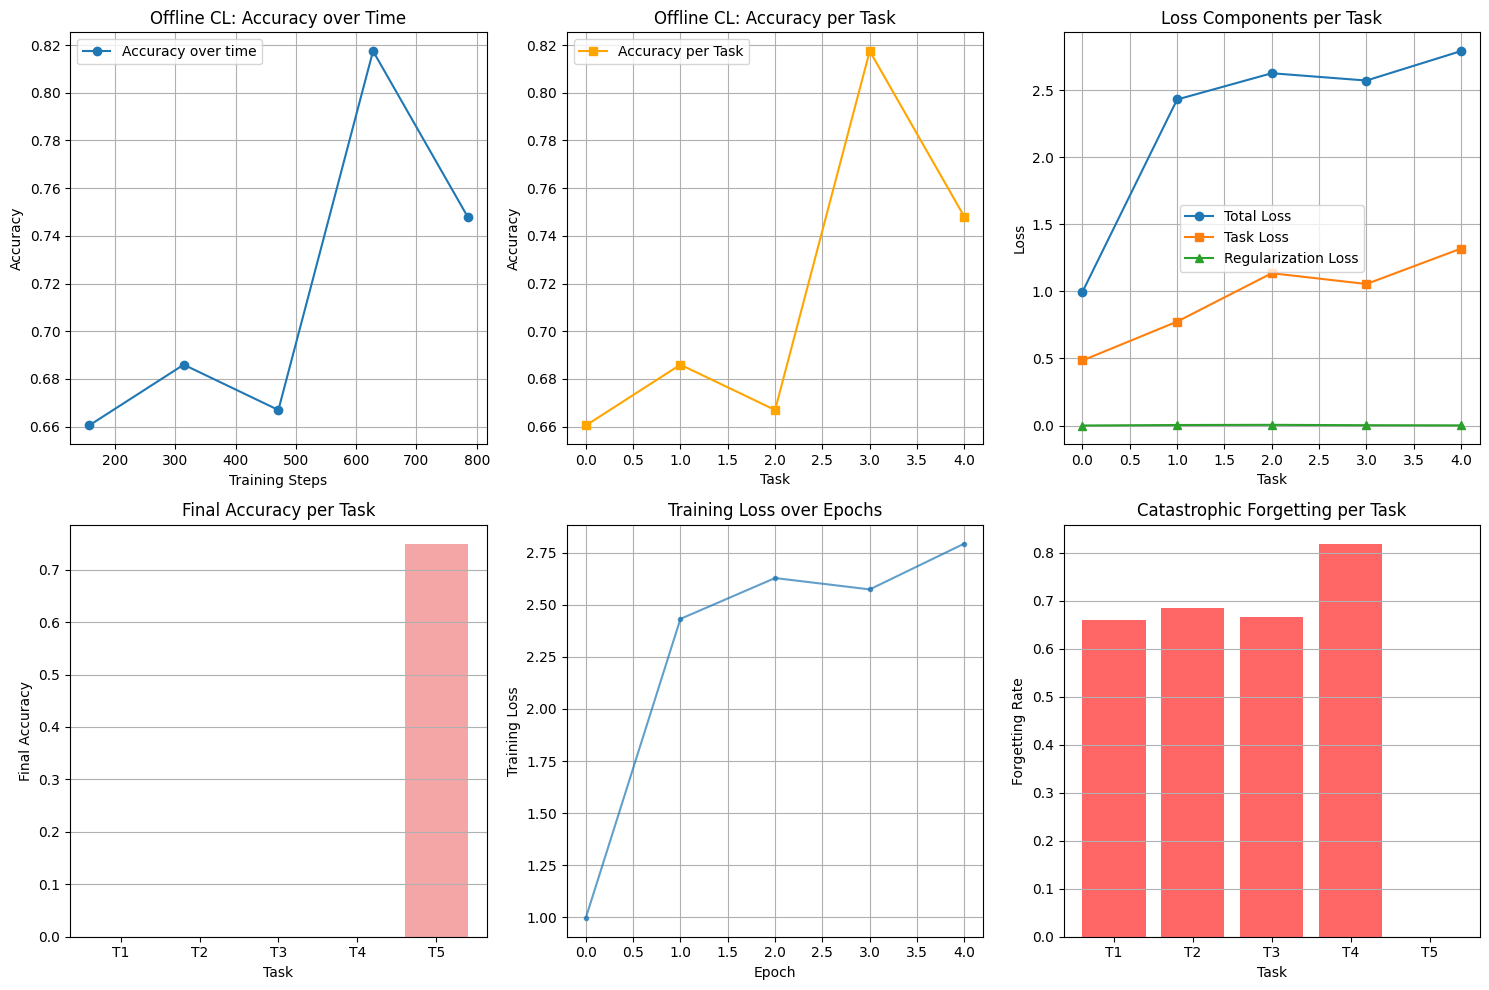

In [23]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = WideResNet(depth=28, n_classes=10, widen_factor=2, dropout=0.3)

# Create dataset loaders (example with CIFAR-10)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                           download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                          download=True, transform=transform)

# Use ImprovedTaskSplitter for train to get class assignments
splitter = ImprovedTaskSplitter(strategy='adaptive_clustering', random_seed=42)
train_loader_fn, _, task_class_assignments = splitter.create_task_loaders(
    base_dataset=train_dataset,
    n_tasks=5,
    batch_size=64,
    model=model,
    device=device,
    shuffle_tasks=True
)

# For test dataset, use the same task_class_assignments to ensure consistent class splits
# Get class to indices for test
if hasattr(test_dataset, 'targets'):
    test_labels = test_dataset.targets
else:
    test_labels = [test_dataset[i][1] for i in range(len(test_dataset))]

test_classes = sorted(set(test_labels))
test_class_to_indices = {cls: [] for cls in test_classes}
for idx, label in enumerate(test_labels):
    test_class_to_indices[label].append(idx)

# Create test task splits
test_task_splits = []
for task_classes in task_class_assignments:
    indices = []
    for cls in task_classes:
        indices.extend(test_class_to_indices.get(cls, []))
    random.shuffle(indices)  # Shuffle if desired
    test_task_splits.append(indices)

# Custom TaskDataset (already defined in the notebook)
class TaskDataset(Dataset):
    def __init__(self, base_dataset, indices):
        self.base_dataset = base_dataset
        self.indices = indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        return self.base_dataset[self.indices[idx]]

# Define test_loader_fn
def test_loader_fn(task_id):
    dataset = TaskDataset(test_dataset, test_task_splits[task_id])
    return DataLoader(dataset, batch_size=64, shuffle=False)

# Now run the pipeline with the improved loaders
trainer = run_cl_pipeline(
    cl_type="offline",
    model=model,
    train_loader_fn=train_loader_fn,
    test_loader_fn=test_loader_fn,
    device=device,
    n_tasks=5,
    n_classes=10,
    evaluating_result=True,
    epochs_per_task=1,
    lr=0.01,
    buffer_size=1000,
    max_mem_size=2000,
    regularizer_type='EWC'
)